# Simple Repetition Code using pytket-quantinuum

## Background on QEC

As you may know, for many of the most attractive applications of quantum computing require the use of quantum error correction.

The basic idea of error correction is to protect the computation from noise by using additonal physical qubits. We protect some subspace for computation by encoding it in a larger quantum state.

In this notebook we will take a look at a quantum circuit that implements the repition code. This is a simple example intended to introduce QEC and show the exectution of quantum-classical circuits.

The repition code is useful for explanatory purposes but isn't considered a "good" quantum code as it can't correct against phase errors.


The distance $d$ repetition code protects 1 quantum bit using $d$ physical qubits.

$$
\begin{equation}
|\bar{0}\rangle = |0\rangle ^{\otimes d} \, , \quad |\bar{1}\rangle = |1\rangle^{\otimes d}
\end{equation}
$$
We will look at the distance 3 vairant (d=3).
$$
\begin{equation}
|\bar{0}\rangle = |000\rangle \, , \quad |\bar{1}\rangle = |111\rangle
\end{equation}
$$

The codespace is $C = \{ |000\rangle \, , |111\rangle\}$. This is a distance 3 code because the codewords differ by 3 bit flips. The minimum Hamming distance between them is 3.

The following notation is used to summarise the properties of a quantum code
$$
\begin{equation}
[[n,\, k,\, d]]
\end{equation}
$$

$n$ - The number of "physical" qubits required to implement the code. 

$k$ - The number of "logical" qubits that can be protected by the code.

$d$ - The "distance" of the code. This is related to the number of faults a code can correct for. a distance $d$ code can correct $\lfloor{\frac{d-1}{2}\rfloor}$ errors.

The three qubit repetition code is a $[[3,\, 1,\, 3]]$ code.

Two well known quantum codes are the $[[9,\, 1,\, 3]]$ Shor code and the $[[7,\, 1,\, 3]]$ Steane code. These protect the state of a single qubit using 9 and 7 qubits respectively.

## Encoding

Here we encode assume that the `data[0]` qubit is in the $|0\rangle$ or $|1\rangle$ state. We can then encode our quantum bit into a 3 qubit quantum state with two CNOT gates.

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = Circuit(name="Repetition Code")
# Add qubit register, the data qubits
data = circuit.add_q_register("data", 3)
circuit.CX(data[0], data[1]).CX(data[0], data[2])
render_circuit_jupyter(circuit)

## Syndrome Extraction

In quantum computing measurement is invasive in the sense that it "collapses" the state. 

To circumvent this we will perform parity measurements on two ancilla qubits. These parity measurements tell us whether an error is likely to have occured and whether we need to take action to correct our state.

Note that for simplicity that we will assume all errors to take place between our encoding step and our syndrome extraction.

We will write these measurement results to a classical register containing 2 bits. These are our syndrome bits.

### Set up registers

In [2]:
# Add ancillas, These are measured in the syndrome extraction stage
ancilla = circuit.add_q_register("anc", 2)

# add syndrome bits
syndrome = circuit.add_c_register("syndrome", 2)

# Add classical registers for the output
output = circuit.add_c_register("output", 3)

circuit.add_barrier(circuit.qubits)

[CX data[0], data[1]; CX data[0], data[2]; Barrier anc[0], anc[1], data[0], data[1], data[2]; ]

### Add Syndrome Measurements

Here we perform a single round of error correction. Note that in practice we typically perform multiple rounds of error correction. We could wrap the following cell in a for loop which we will do later on.

In [3]:
from pytket import OpType

circuit.CX(data[0], ancilla[0])
circuit.CX(data[1], ancilla[0])
circuit.Measure(ancilla[0], syndrome[0])
circuit.add_gate(OpType.Reset, [ancilla[0]])
# Syndrome Extraction
circuit.CX(data[1], ancilla[1])
circuit.CX(data[2], ancilla[1])
circuit.Measure(ancilla[1], syndrome[1])
circuit.add_gate(OpType.Reset, [ancilla[1]])

render_circuit_jupyter(circuit)

## Decoding

Now that we've made our syndrome measurements we need to do some classical processing to determine where we need to make our corrections.

Decoding typically requires some non-trivial processing at quantum runtime often using algorithms such as minimum weight perfect matching.

In our simplified example we will use register comparison operations. These operations are not supported in the standard OpenQASM 2.0 but are supported using extended QASM with the "hqslib1" qasm header.

These operations are supported by the quantinnum stack so we can compile and execute circuits to perform these operations at runtime.


```python
circuit.X(data[1], condition=reg_eq(syndrome, 3))
```
This means...

If the value of the syndrome register is equal to 3 (little endian), apply X. Else, do nothing.

In [4]:
from pytket.circuit.logic_exp import reg_eq

# Correction
circuit.X(data[0], condition=reg_eq(syndrome, 1))
circuit.X(data[1], condition=reg_eq(syndrome, 3))
circuit.X(data[2], condition=reg_eq(syndrome, 2))

render_circuit_jupyter(circuit)

Now we can measure out our three data qubits.

In [5]:
circuit.Measure(data[0], output[0])
circuit.Measure(data[1], output[1])
circuit.Measure(data[2], output[2])

render_circuit_jupyter(circuit)

In [6]:
def pytket_rep_code_3(T: int, correction: bool, add_error: bool) -> Circuit:
    # Set up Repetition Code with mid-circuit measurement and corrections
    circuit = Circuit(name="Repetition Code")
    # Add qubit register, the data qubits
    data = circuit.add_q_register("data", 3)
    # Add qubit register, the ancilla qubit
    ancilla = circuit.add_q_register("anc", 2)
    # Add classical registers for the syndromes
    syndrome = circuit.add_c_register("syndrome", 2)
    # Add classical registers for the output
    output = circuit.add_c_register("output", 3)
    
    # encoding
    circuit.CX(data[0], data[1]).CX(data[0], data[2])
    circuit.add_barrier(circuit.qubits)

    # add a bitflip error
    if add_error:
        circuit.X(data[2]) 

    #Repeat the rounds of syndrome extraction T times
    for _ in range(T):
        # Syndrome Extraction
        circuit.CX(data[0], ancilla[0])
        circuit.CX(data[1], ancilla[0])
        circuit.Measure(ancilla[0], syndrome[0])
        circuit.add_gate(OpType.Reset, [ancilla[0]])
        # Syndrome Extraction
        circuit.CX(data[1], ancilla[1])
        circuit.CX(data[2], ancilla[1])
        circuit.Measure(ancilla[1], syndrome[1])
        circuit.add_gate(OpType.Reset, [ancilla[1]])
        if correction:
            # Correction
            circuit.X(data[0], condition=reg_eq(syndrome, 1))
            circuit.X(data[1], condition=reg_eq(syndrome, 3))
            circuit.X(data[2], condition=reg_eq(syndrome, 2))
            
    # Measure out data qubits
    circuit.Measure(data[0], output[0])
    circuit.Measure(data[1], output[1])
    circuit.Measure(data[2], output[2])
    return circuit

In [7]:
from pytket.utils.stats import gate_counts

dist_three_circuit_no_error = pytket_rep_code_3(T=3, correction=True, add_error=False)

render_circuit_jupyter(dist_three_circuit_no_error)

gate_counts(dist_three_circuit_no_error)

Counter({<OpType.CX: 42>: 14,
         <OpType.Measure: 61>: 9,
         <OpType.RangePredicate: 17>: 9,
         <OpType.Conditional: 102>: 9,
         <OpType.Reset: 63>: 6,
         <OpType.Barrier: 8>: 1})

In [8]:
from pytket.extensions.quantinuum import QuantinuumBackend

In [9]:
backend = QuantinuumBackend("H1-1E")

backend.login()

Enter your Quantinuum email:  callum.macpherson@quantinuum.com
Enter your Quantinuum password:  ········


In [10]:
compiled_circuit1 = backend.get_compiled_circuit(dist_three_circuit_no_error, optimisation_level=0)

In [11]:
# Is our circuit valid?
backend.valid_circuit(compiled_circuit1)

True

In [12]:
render_circuit_jupyter(compiled_circuit1)
gate_counts(compiled_circuit1)

Counter({<OpType.Rz: 36>: 56,
         <OpType.PhasedX: 66>: 28,
         <OpType.Conditional: 102>: 18,
         <OpType.ZZPhase: 71>: 14,
         <OpType.Measure: 61>: 9,
         <OpType.RangePredicate: 17>: 9,
         <OpType.Reset: 63>: 6,
         <OpType.Barrier: 8>: 1})

In [13]:
shots = 300 # execute circuit for a given number of shots

In [14]:
handle1 = backend.process_circuit(compiled_circuit1, n_shots=shots)

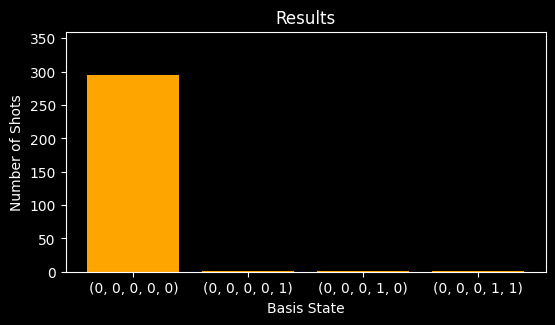

Counter({(0, 0, 0, 0, 0): 295, (0, 0, 0, 0, 1): 1, (0, 0, 0, 1, 0): 1, (0, 0, 0, 1, 1): 1, (0, 0, 1, 0, 0): 1, (0, 0, 1, 0, 1): 1})


In [15]:
from plotting import plot_results

result1 = backend.get_result(handle1)
plot_results(result1, dark_mode=True, y_limit=1.2*shots)
print(result1.get_counts())

In [16]:
# run the circuit again with the bit flip error
dist_three_circuit_with_error = pytket_rep_code_3(T=3, correction=True, add_error=True)
compiled_circuit2 = backend.get_compiled_circuit(dist_three_circuit_with_error, optimisation_level=0)

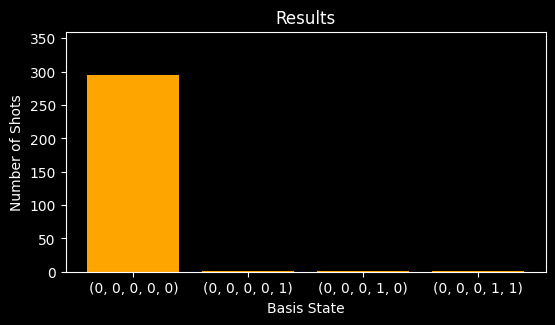

Counter({(0, 0, 0, 0, 0): 295, (0, 0, 0, 0, 1): 1, (0, 0, 0, 1, 0): 1, (0, 0, 0, 1, 1): 1, (0, 0, 1, 0, 0): 1, (0, 0, 1, 0, 1): 1})


In [17]:
handle2 = backend.process_circuit(compiled_circuit2, n_shots=shots)
result2 = backend.get_result(handle1)
plot_results(result2, dark_mode=True, y_limit=1.2*shots)
print(result2.get_counts())                            